# Sentence feature evolution, excluding stopwords

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False
STOPWORDS = 'exclude'  # 'include' or 'exclude'

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_pilot_8c


Imports for the analysis

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sb

from gists.models import Sentence, Tree, GistsConfiguration

from analysis.utils import memoized, mpl_palette

config = GistsConfiguration.get_solo()

## 2 Long-term sentence feature evolution

### A note on the features used

The following features, defined on the sentences themselves, are used in the plots below:
* `token length`: number of words in the sentence.
* `content length`: number of content words in the sentence.
* `root memorable`: whether the root sentence was marked as a memorable quote or not.
* `oc rate`: "ordered content transformation rate". Measures how a sentence is transformed when rewritten. It's the levenshtein distance between the lists of content words of the sentence and its direct child, normalised to the maximum length of that list for child or parent. Depending on the graph, root sentences are counted as a single measure (with `oc rate` averaged over their children), or are counted as a separate measure for each child, whichever makes more sense.
* `oc transmitted`: "ordered content transmitted". Measures whether the list of content words of a sentence was transmitted perfectly or not (same words, same order). It's a boolean, represented as 0 or 1, and corresponds to `oc_rate == 0`. The same note above about root sentences applies.
* `dep depth`: depth of the dependency tree of the sentence.
* `relatedness`: average distance between all pairs of content words in the sentence (distance is cosine between words' vector representations).
* `1 gram word`: cross-entropy of the sentence according to unigram language model trained on the newswire portion of the Brown corpus (as [Danescu-Niculescu-Mizil et al. (2012)](http://arxiv.org/abs/1203.6360) do). It's the negated average log-probability of the ngrams in the sentence, for this language model. In other words:
$$e = - \left< \log p\left( w \left| (n-1) \text{ preceding words} \right. \right) \right>_{w \in sentence}$$
where $p(w|\text{preceding words})$ is given by the language model, and $n$ is the size of the model's ngrams. So it measures how surprising the sentence's word sequence is, compared to the Brown newswire corpus.
* `2 gram word`: cross-entropy of the sentence according to bigram language model (same notes as above).
* `3 gram word`: cross-entropy of the sentence according to trigram language model (same notes as above).
* `1 gram tag`: cross-entropy of the sentence's POS tags according to unigram POS language model (same notes as above). Measures how surprising the sentence's POS sequence is, compared to the Brown newswire corpus. So its more a grammatical measure.
* `2 gram tag`: cross-entropy of the sentence's POS tags according to bigram POS language model (same notes as above).
* `3 gram tag`: cross-entropy of the sentence's POS tags according to trigram POS language model (same notes as above).

To all this we add features defined on words (frequency, age-of-acquisition, etc.), averaged over all words in the sentence (with or without stopwords, depending on the value of `STOPWORDS`).

"Content words", in the above, means "non-stopwords".

The idea here is to explore all the plots we can imagine, to have a global descriptive view. Depending on the graphs, the first five features may not appear if they don't make sense (or if they represent another dimension).

### 2.0 Setup

We need an additional feature-building function

In [4]:
def _stopword_proportion(self, _):
    """stopword %"""
    return 1 - (len(self.content_tokens) / len(self.tokens))

Sentence._stopword_proportion = _stopword_proportion
Sentence.SENTENCE_FEATURES.add('stopword_proportion')

Then build the master DataFrame that we'll plot below

In [5]:
def additional_features(parent, child):
    return {
        'oc_rate': np.nan if child is None else parent.oc_distance(child),
        'oc_transmitted': np.nan if child is None else int(parent.oc_distance(child) == 0),
        'token_length': len(parent.tokens),
        'content_length': len(parent.content_tokens),
    }

def base(parent, child):
    return {
        # indices
        'tree_id': parent.tree.id,
        'sentence_id': parent.id,
        'branch_id': parent.head.id if parent.parent is not None else child.head.id,
        'child_id': child.id if child is not None else np.nan,
        # independent variables
        'depth': parent.depth,
        'is_root': parent.parent is None,
        'root_memorable': int(parent.tree.id % 2 == 0),
    }

def rows(parent, child):
    for fname in set(Sentence.WORD_FEATURES.keys()).union(Sentence.SENTENCE_FEATURES):
        row = base(parent, child)
        row.update({'feature': fname, 'value': parent.feature(fname, stopwords=STOPWORDS)})
        yield row
    
    for fname, fvalue in additional_features(parent, child).items():
        row = base(parent, child)
        row.update({'feature': fname, 'value': fvalue})
        yield row

In [6]:
data = []
for tree in Tree.objects.experiment:
    for sentence in tree.sentences.kept:

        if sentence.depth > config.target_branch_depth:
            # Ignore out-of-shape sentences
            continue
        
        child_rows = []
        for child in sentence.children.kept:
            if child.depth > config.target_branch_depth:
                continue
            for row in rows(sentence, child):
                child_rows.append(row)
        for row in (child_rows or rows(sentence, None)):
            data.append(row)

data = pd.DataFrame(data)

features = sorted(set(data.feature))
index = sorted(set(data.columns).difference(['value', 'feature']))

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



A helper function to reshape the DataFrame as needed

In [7]:
def extract_features(df, df_index, features):
    edf = pd.melt(df.pivot_table(index=df_index, columns='feature', values='value').reset_index(),
                  id_vars=df_index + features, var_name='feature')
    efeatures = sorted(set(edf.feature).difference(features))
    return edf, efeatures

And define a few plotting functions

In [8]:
# Imports
from matplotlib import cm
from matplotlib.patches import Ellipse

def pretty_plot_correlations(data, scaling=1.0, cor_fontsize=30.0, label_fontsize=35.0):
    """Pretty-plot a correlation matrix.
    
    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing the variables for which to plot the correlation matrix.
    scaling : float, optional
        Scaling factor for the whole figure; for instance `2.0` would
        create a figure twice as big (for better resolution when saving);
        defaults to 1.0.
    cor_fontsize : float, optional
        Font size for the correlation values; defaults to 30.0.
    label_fontsize : float, optional
        Font size for the labels; defaults to 35.0.
    
    """
    
    # Some layout definitions.
    ellipse_lwidth = 1.5
    sep_crop = 0.2
    
    # Precompute useful values.
    correlations = data.corr()
    n_features = len(correlations)
    lims = np.linspace(0, 1, n_features + 1)
    step = 1 / n_features
    xs = lims[:-1] + step / 2
    esize = 0.98 * step
    
    # Create our figure.
    fig, ax = plt.subplots(figsize=(4 * scaling, 4 * scaling))
    
    # For all couples...
    for i in range(n_features):
        for j in range(n_features):
            # ...compute coordinates...
            x = xs[j]
            y = 1 - xs[i]
            cor = correlations.iloc[i, j]
            
            if i < j:
                # ...plot an Ellipse...
                color = cm.bwr((1 - cor) / 2)
                ax.add_patch(Ellipse([x, y], esize, esize * (1 - abs(cor)),
                             angle=np.sign(cor) * 45, ls='solid', lw=ellipse_lwidth,
                             ec='black', fc=color, alpha=0.8))
            
            elif i > j:
                # ...or show the correlation value.
                ax.text(x, y, "{:.2f}".format(cor).rstrip("0"),
                        fontsize=cor_fontsize,
                        horizontalalignment='center',
                        verticalalignment='center')
    
    # Add the line separators and labels.
    for i in range(n_features):
        # Line separator
        ax.plot([(i + sep_crop) * step, (i + 1 - sep_crop) * step],
                [1 - (i + 1 - sep_crop) * step, 1 - (i + sep_crop) * step],
                'k-', lw=ellipse_lwidth)
        
        # Horizontal label
        ax.text(- step / 2, 1 - step / 2 - i * step,
                correlations.columns[i], fontsize=label_fontsize,
                horizontalalignment='right', verticalalignment='center')
        
        # Vertical label
        ax.text(step / 2 + i * step, 1 + step / 2,
                correlations.columns[i], fontsize=label_fontsize, rotation='vertical',
                horizontalalignment='center', verticalalignment='bottom')
    
    # Finally, set the axis limits and hide the axis themselves.
    ax.set_xlim(- 0.1, 1.1)
    ax.set_ylim(- 0.1, 1.1)
    ax.axis('off')
    
    return fig

In [9]:
def plot_feature_evolution(x, y, **kwargs):
    color = kwargs.get('color', sb.color_palette()[0])
    data = kwargs['data']
    label = kwargs.get('label')
    if 'sentence_id' in data.columns:
        # Average repeated measures (which we have for the roots)
        data = data.groupby('sentence_id', as_index=False).mean()
    x_y = data.groupby(x)[y]

    # Compute features per depth
    heights = x_y.mean()
    cis = (x_y.std(ddof=1)
           * stats.t.ppf(1 - .05/2, x_y.size() - 1)
           / np.sqrt(x_y.size()))

    # Plot
    ax = plt.gca()
    ax.plot(heights.index, heights, color=color)

    ax.fill_between(heights.index, heights - cis, heights + cis,
                    color=sb.desaturate(color, 0.2), alpha=0.2)

    if label is not None:
        # Add a dummy scatterplot so we can get legend data
        ax.scatter([], [], color=color, label=label)

In [10]:
def plot_trajectories(x, y, **kwargs):
    data = kwargs.pop('data')
    x_name = y_name = ''
    if isinstance(x, str):
        x_name = x
        x = data.groupby('sentence_id')[x_name].first().values
    if isinstance(y, str):
        y_name = y
        y = data.groupby('sentence_id')[y_name].first().values
    ax = kwargs.get('ax', plt.gca())
    
    # Get indices
    indices = {}
    sentences_ids = data.groupby('sentence_id').first().index
    for i, sentence_id in enumerate(sentences_ids):
        indices[sentence_id] = i
    
    # Get root and leaves
    assert len(set(data.tree_id)) == 1
    tree_id = data.tree_id.iloc[0]
    assert len(set(data[data.is_root].tree_id)) == 1
    root_id = data[data.is_root].tree_id.iloc[0]
    size = len(sentences_ids)
    leaves_ids = set(data[np.isnan(data.child_id)].sentence_id)
    sentence_heads = dict(data[~data.is_root][['sentence_id', 'branch_id']].values)
    
    # Define colors
    heads_indices = {}
    heads_ids = set(data.branch_id)
    for i, head_id in enumerate(heads_ids):
        heads_indices[head_id] = i
    cmap, palette = mpl_palette(len(heads_indices))
    
    # Plot sentences
    leaves_indices = [indices[leaf_id] for leaf_id in leaves_ids]
    colors = np.array([(.5, .5, .5, 1)] * size)
    colors[indices[root_id]] = (.7, 0, 0, 1)
    if len(leaves_ids) > 0:
        colors[leaves_indices] = [palette[heads_indices[sentence_heads[leaf_id]]]
                                  for leaf_id in leaves_ids]
    sizes = np.ones(size) * 50
    sizes[indices[root_id]] = 200
    if len(leaves_ids) > 0:
        sizes[leaves_indices] = 200
    ax.scatter(x[:], y[:], c=colors, s=sizes, edgecolors=(0, 0, 0, 0))
    
    # Plot links
    links = data[['sentence_id', 'child_id']].dropna().values
    segments = [[[x[indices[s_id]], y[indices[s_id]]],
                 [x[indices[child_id]], y[indices[child_id]]]]
                for (s_id, child_id) in links]
    colors = np.array([heads_indices[sentence_heads[child_id]]
                       for (_, child_id) in links])
    lc = LineCollection(segments,
                        zorder=1, cmap=cmap,
                        norm=plt.Normalize(0, colors.max()))
    lc.set_array(colors)
    lc.set_linewidths(1.5 * np.ones(len(segments)))
    ax.add_collection(lc)
    
    # Set legend data (seaborn catches legend stuff if we do it here,
    # so we return some data by this mechanism and use it in the
    # plotting code after FacetGrid.map_dataframe()).
    legends = kwargs.get('legends', None)
    if legends is not None:
        legend_handles = []
        for i, head_id in enumerate(heads_ids):
            legend_handles.append(Patch(color=palette[heads_indices[head_id]],
                                        label='#{}'.format(head_id)))
        legends[tree_id] = legend_handles
    
    # Set chrome
    if kwargs.get('set_chrome', False):
        ax.set_title('tree id = {}'.format(tree_id))
        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)

In [11]:
def plot_relation(x, y, **kwargs):
    color = kwargs.get('color', sb.color_palette()[0])
    data = kwargs['data']
    ax = kwargs.get('ax', plt.gca())
    binning = kwargs.get('binning')
    quantiles = kwargs.get('quantiles', False)
    label = kwargs.get('label')
    if 'sentence_id' in data.columns:
        # Average repeated measures (which we have for the roots)
        data = data.groupby('sentence_id', as_index=False).mean()
    x = data[x]
    y = data[y]
    
    # Compute binning
    if binning is not None:
        cut, cut_kws = ((pd.qcut, {}) if quantiles
                        else (pd.cut, {'right': False}))
        for bin_count in range(binning, 0, -1):
            try:
                x_bins, bins = cut(x, bin_count, labels=False,
                                   retbins=True, **cut_kws)
                break
            except ValueError:
                pass
        if bin_count <= 1:
            return
        middles = (bins[:-1] + bins[1:]) / 2
    else:
        middles = np.arange(x.values.min(), x.values.max() + 1)
        x_bins = x.values - x.values.min()
        bin_count = len(middles)

    # Compute features per depth
    heights = np.zeros(bin_count)
    cis = np.zeros(bin_count)
    for i in range(bin_count):
        indices = x_bins == i
        n = indices.sum()
        heights[i] = y[indices].mean()
        cis[i] = (stats.t.ppf(.975, n - 1) * y[indices].std(ddof=1)
                  / np.sqrt(n))

    # Plot
    ax.plot(middles, heights, color=color)
    ax.fill_between(middles, heights - cis, heights + cis,
                    color=sb.desaturate(color, 0.2), alpha=0.2)

    if label is not None:
        # Add a dummy scatterplot so we can get legend data
        ax.scatter([], [], color=color, label=label)

### 2.1 Feature interactions

#### 2.1.1 Pretty matrix

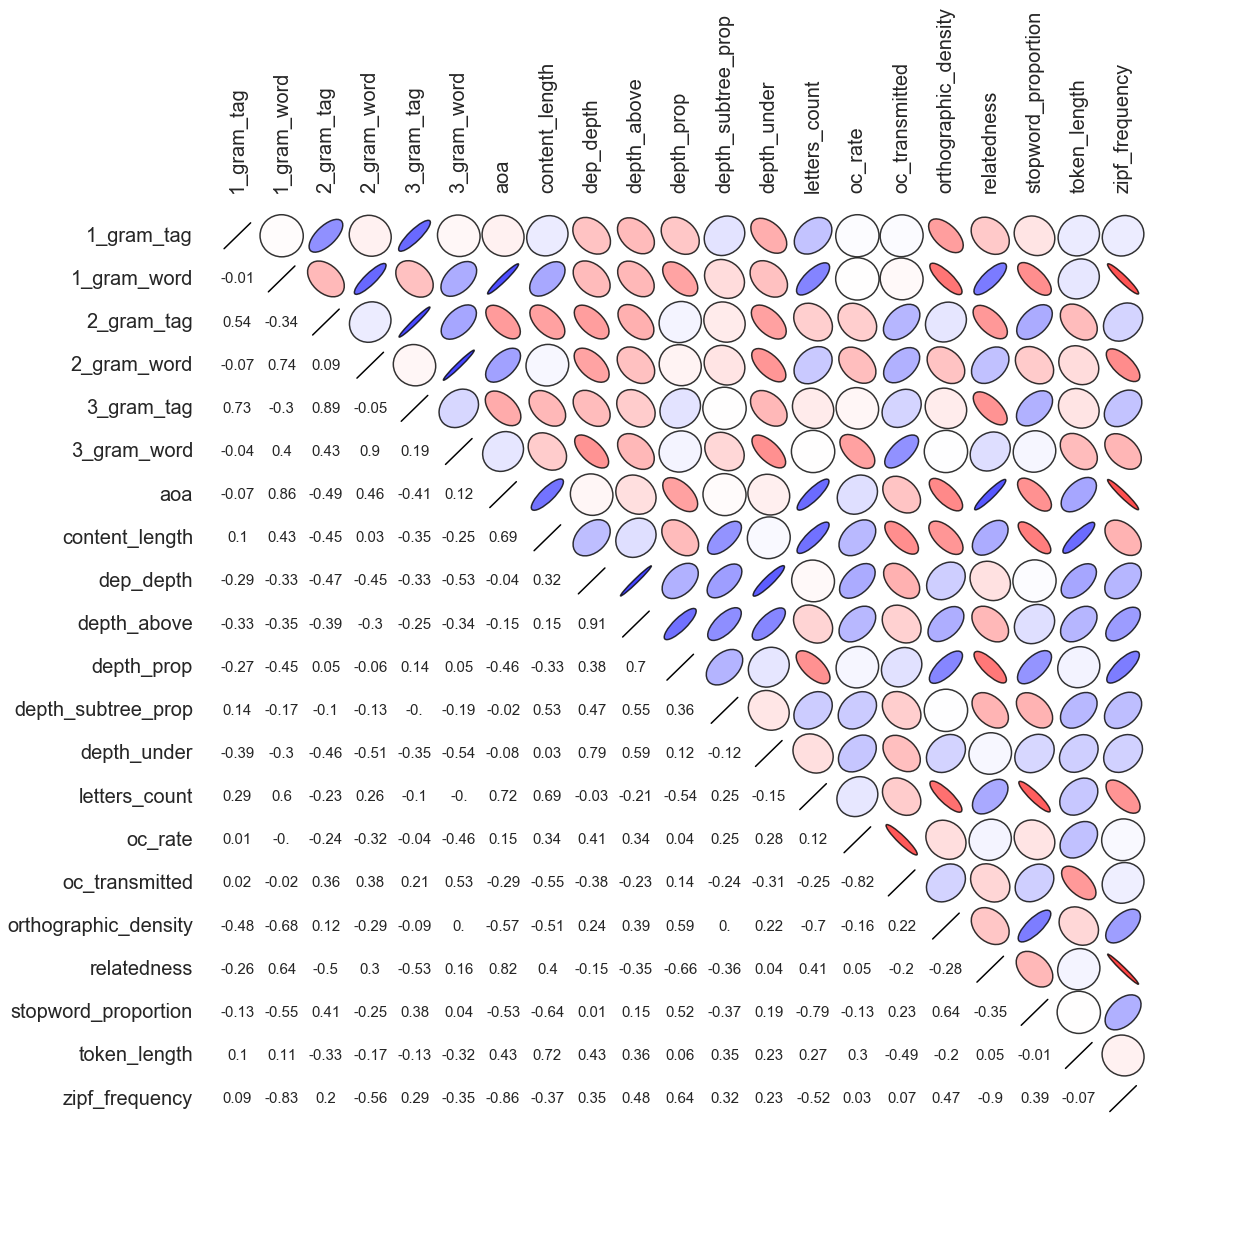

In [12]:
pretty_plot_correlations(data.pivot_table(index=index, columns='feature', values='value'),
                         scaling=5, cor_fontsize=15, label_fontsize=20);

#### 2.1.2 Full detail

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.

/home/sl/.virtualenvs/interpretation-experiment.analysis/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.



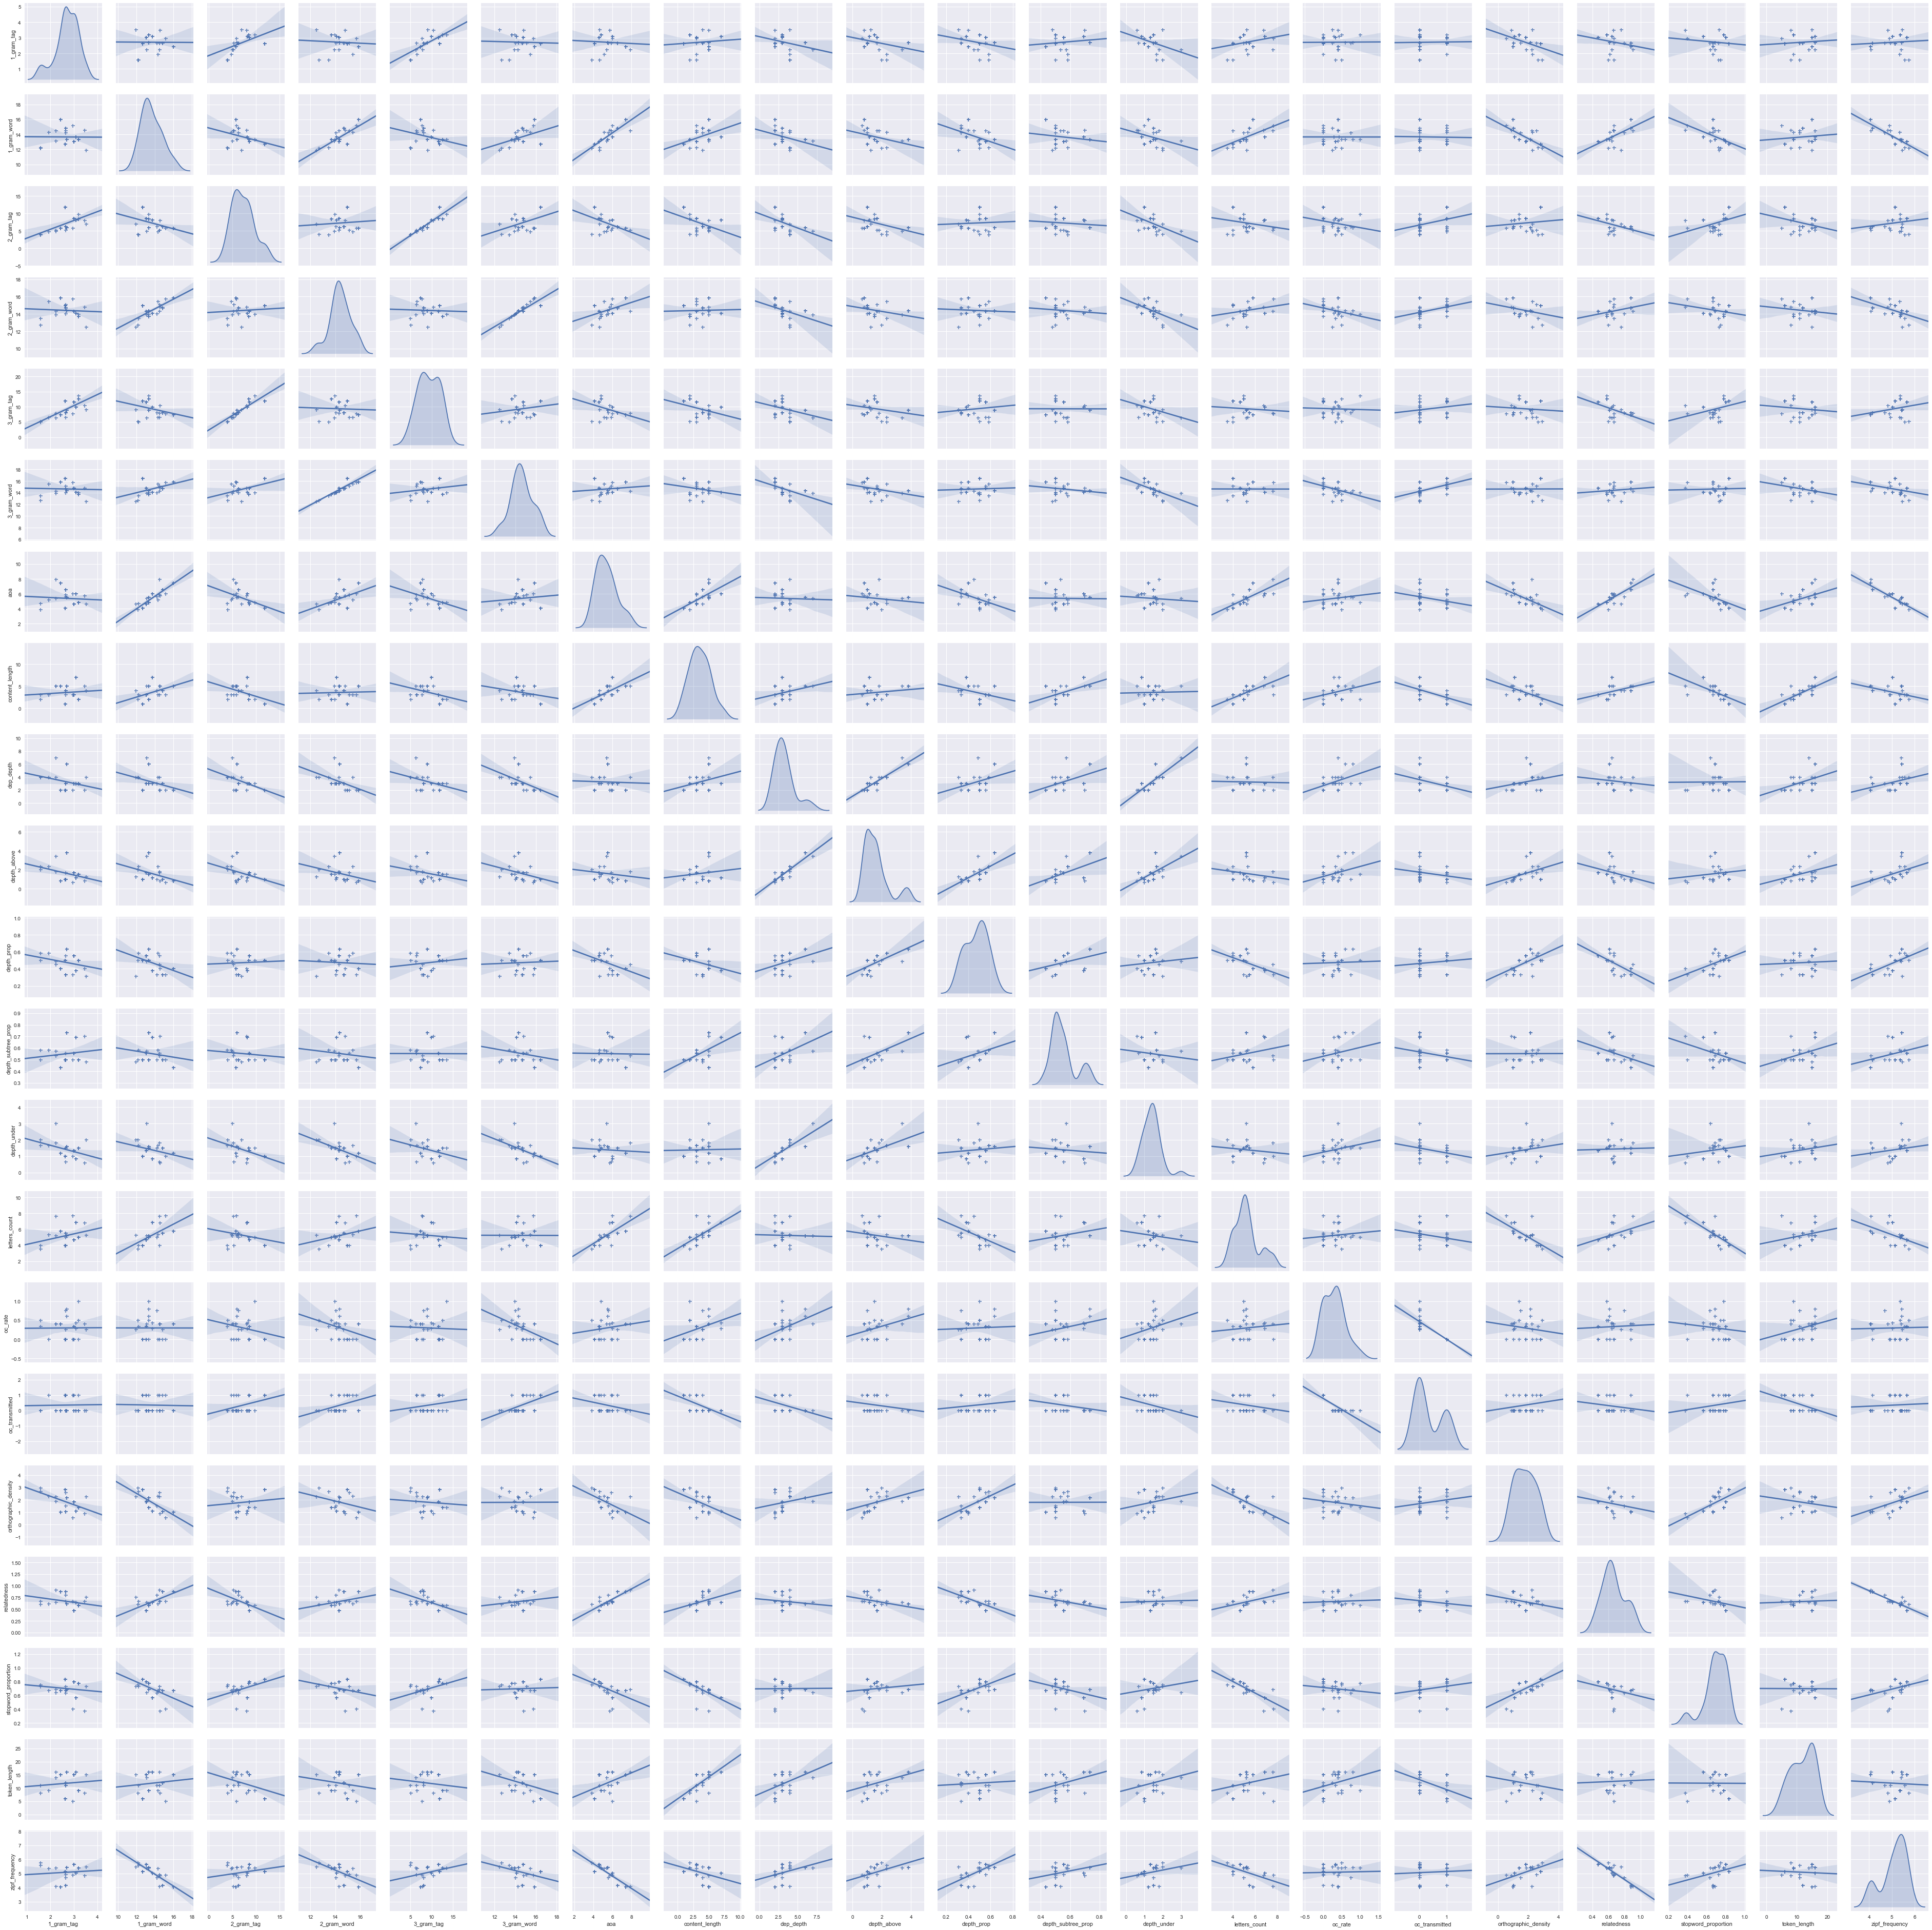

In [13]:
sb.pairplot(data.pivot_table(index=index, columns='feature', values='value'),
            kind='reg', markers="+",
            diag_kind="kde", diag_kws=dict(shade=True))

### 2.2 Feature ~ depth

#### 2.2.1 Feature ~ depth

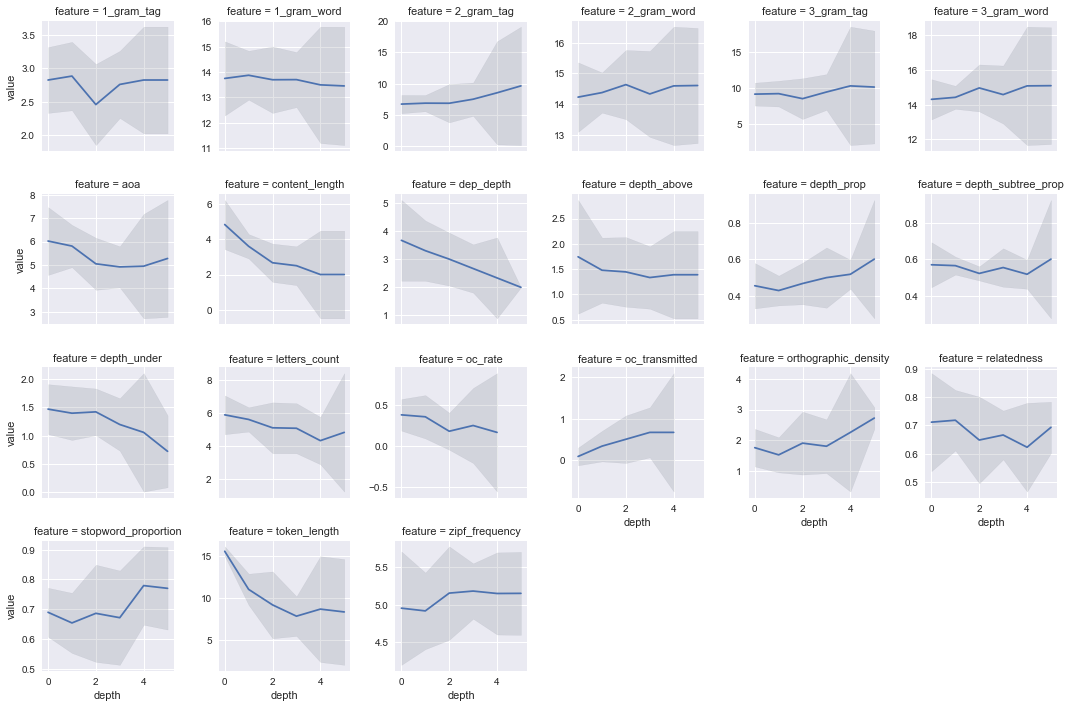

In [14]:
g = sb.FacetGrid(data=data,
                 dropna=False, col='feature', col_order=features,
                 col_wrap=6, size=2.5, sharey=False)
g.map_dataframe(plot_feature_evolution, 'depth', 'value')

#### 2.2.2 Feature ~ depth * memorability of root

In [15]:
#g = sb.FacetGrid(data=data,
#                 dropna=False, col='feature', col_order=features,
#                 hue='root_memorable',
#                 col_wrap=6, size=2.5, sharey=False)
#g.map_dataframe(plot_feature_evolution, 'depth', 'value').add_legend()

#### 2.2.3 Feature ~ depth / tree

In [16]:
#for feature in features:
#    g = sb.FacetGrid(data=data[data.feature == feature],
#                     dropna=False, col='tree_id',
#                     col_wrap=10, size=1.5)
#    g.map_dataframe(plot_feature_evolution, 'depth', 'value')
#    g.set_ylabels(feature)

#### 2.2.4 Feature ~ depth * branch / tree

In [ ]:
tree_ids = data.groupby('sentence_id')['tree_id'].first()
for feature in features:
    legends = {}
    g = sb.FacetGrid(data=data[data.feature == feature],
                     dropna=False, col='tree_id',
                     col_wrap=10, size=4)
    g.map_dataframe(plot_trajectories, 'depth', 'value', legends=legends)
    for i, ax in enumerate(g.axes):
        ax.legend(handles=legends[tree_ids.iloc[i]])
    g.set_ylabels(feature)

#### 2.2.5 Feature ~ depth / number of content words

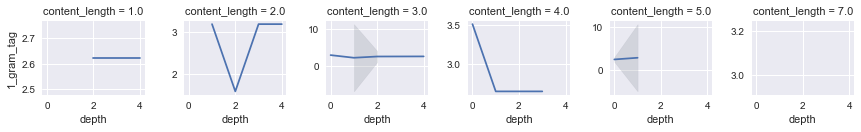

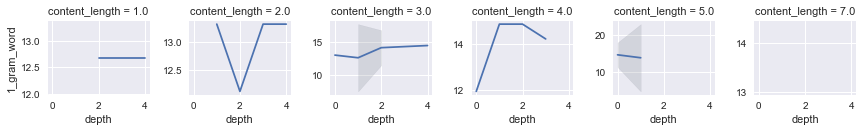

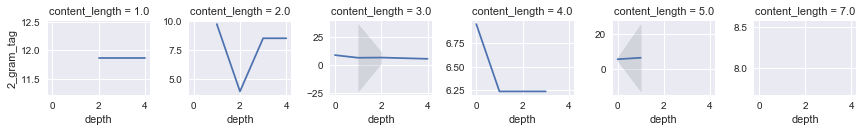

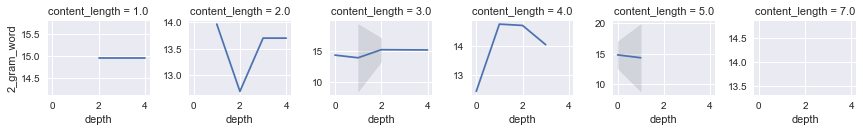

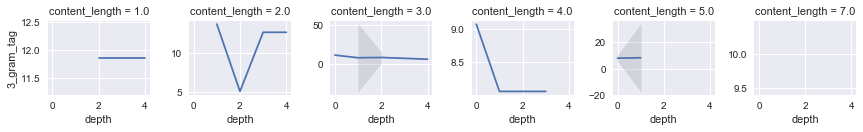

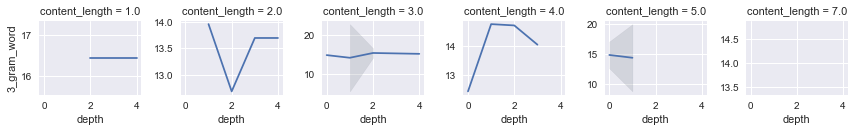

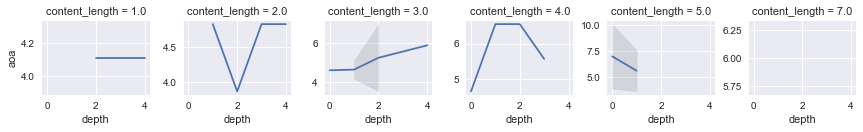

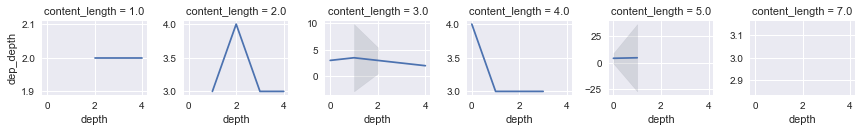

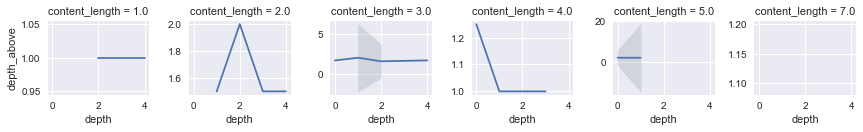

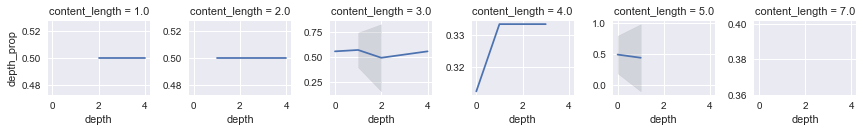

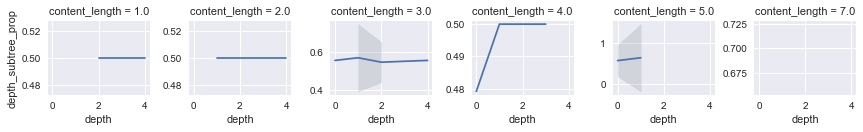

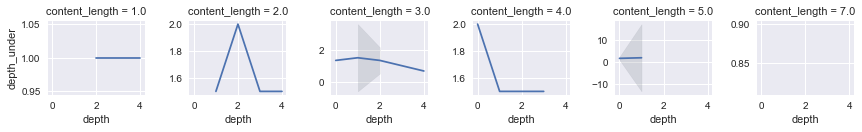

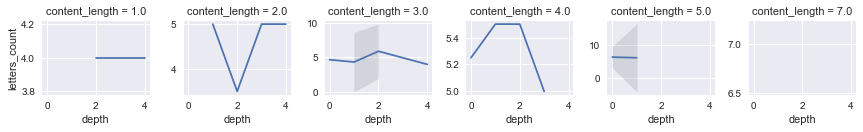

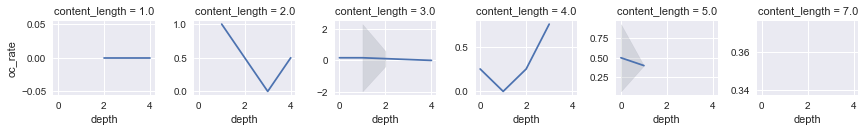

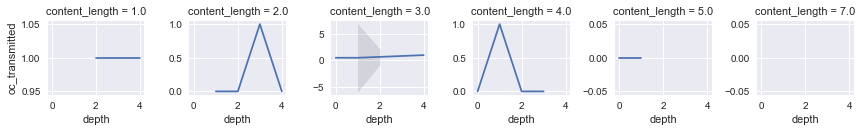

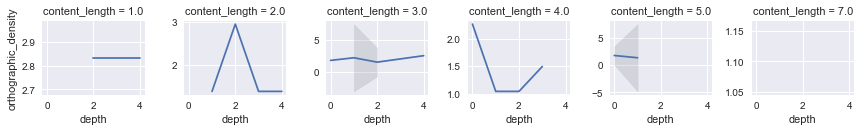

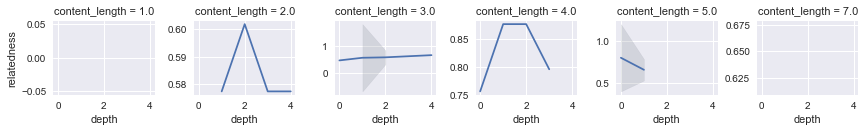

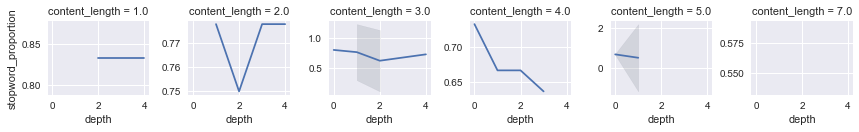

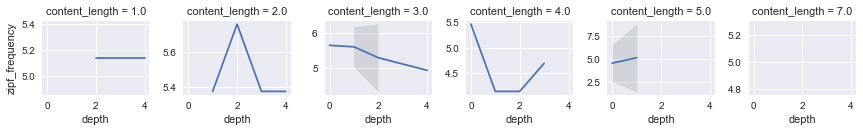

In [18]:
data_lengths, features_lengths = extract_features(data, index, ['token_length', 'content_length'])
for feature in features_lengths:
    g = sb.FacetGrid(data=data_lengths[data_lengths.feature == feature],
                     dropna=False, col='content_length',
                     sharey=False,
                     col_wrap=10, size=2)
    g.map_dataframe(plot_feature_evolution, 'depth', 'value')
    g.set_ylabels(feature)

#### 2.2.6 Feature ~ depth * memorability of root / number of content words

In [19]:
#for feature in features:
#    g = sb.FacetGrid(data=data_lengths[data_lengths.feature == feature],
#                     dropna=False, col='content_length',
#                     hue='root memorable',
#                     sharey=False,
#                     col_wrap=10, size=2)
#    g.map_dataframe(plot_feature_evolution, 'depth', 'value').add_legend()
#    g.set_ylabels(feature)

### 2.3 Feature distribution aggregating all depths

#### 2.3.1 Feature distribution (root sentences) * memorability of root

In [20]:
#width = 6
#height = int(np.ceil(len(features_lengths) / width))
#fig, axes = plt.subplots(height, width, figsize=(4 * width, 4 * height))
#for j in range(len(features_lengths), width * height):
#    axes.ravel()[j].set_visible(False)
#for i, feature in enumerate(features_lengths):
#    ids = data_lengths.is_root & (data_lengths.feature == feature)
#    # Use a violinplot in a for loop, instead of a factorplot/FacetGrid,
#    # since the behaviour for repeated measures is different according to the feature
#    sb.violinplot(ax=axes.ravel()[i], y='value', x='root_memorable',
#                  data=(data_lengths[ids]
#                        if ('rate' in feature) or ('transmitted' in feature)
#                        # For non transmission-related features, remove repeated measures
#                        else data_lengths[ids].groupby('sentence_id').first()),
#                  size=3)
#    if i < len(features_lengths) - width:
#        axes.ravel()[i].set_xlabel('')
#        axes.ravel()[i].set_xticklabels([])
#    axes.ravel()[i].set_ylabel('')
#    axes.ravel()[i].set_title(feature)

#### 2.3.2 Feature distribution (all sentences) * content words perfectly transmitted or not

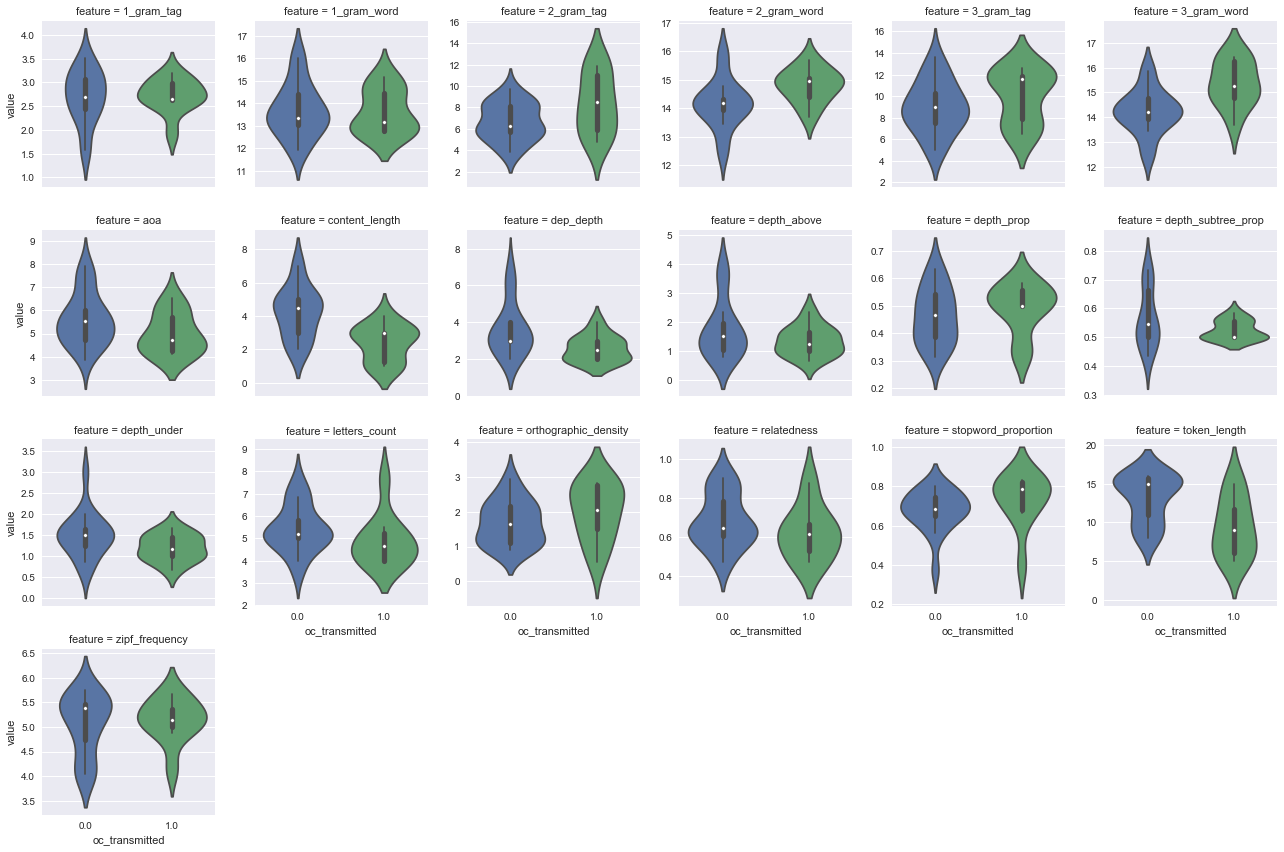

In [21]:
data_transmitted, features_transmitted = extract_features(data, index, ['oc_rate', 'oc_transmitted'])
sb.factorplot(y='value', x='oc_transmitted',
              data=data_transmitted,
              col='feature', col_wrap=6, col_order=features_transmitted,
              sharey=False,
              kind='violin', size=3)

#### 2.3.3 Feature distribution (all sentences) * content words perfectly transmitted or not / number of content words

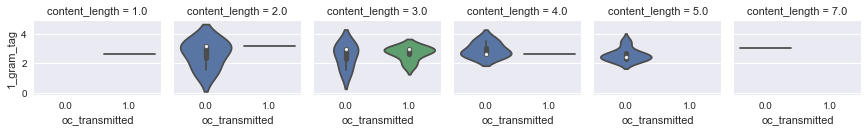

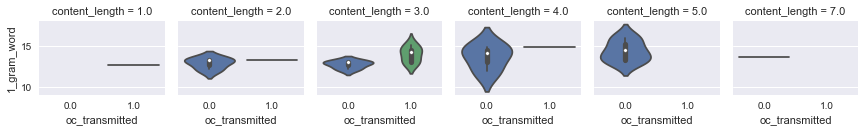

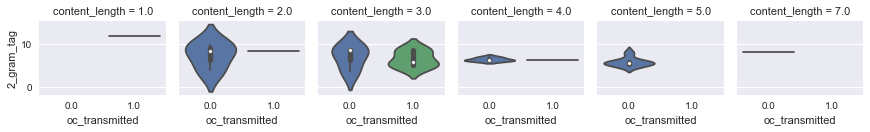

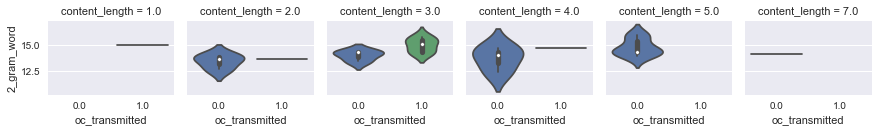

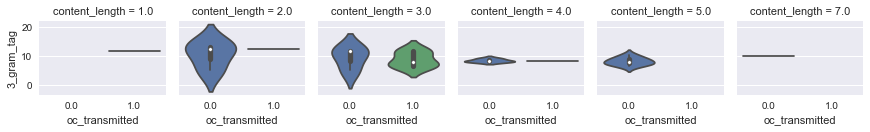

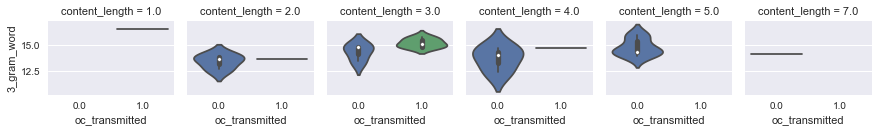

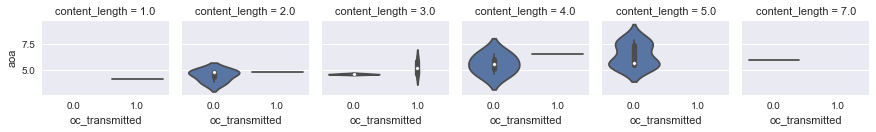

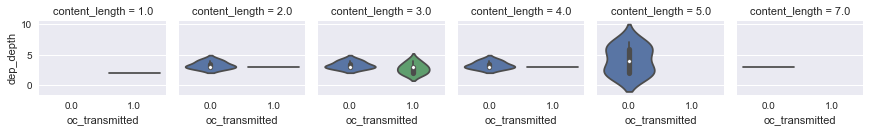

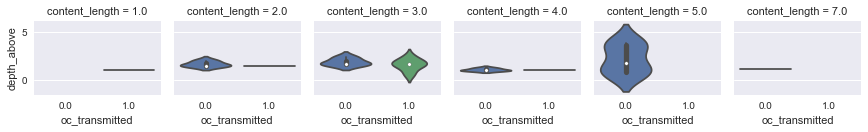

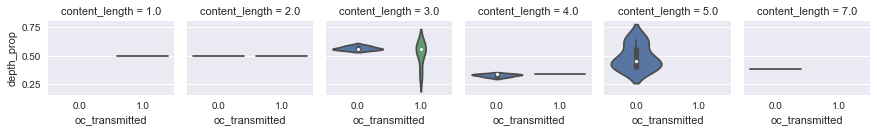

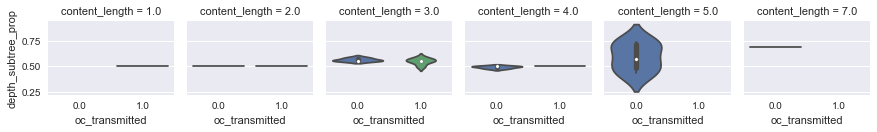

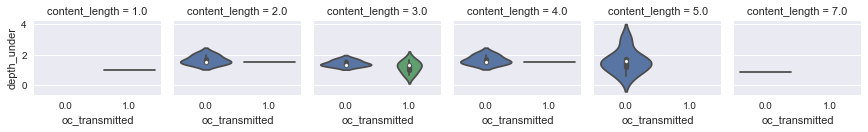

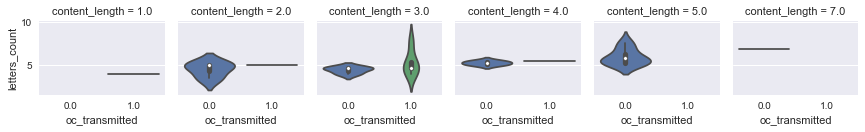

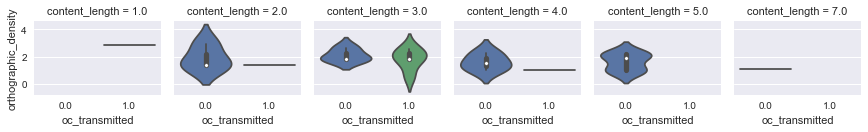

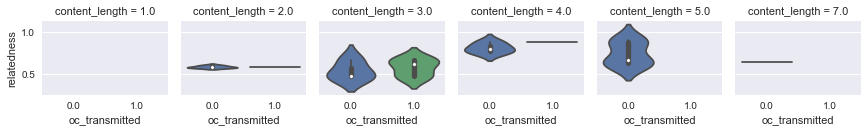

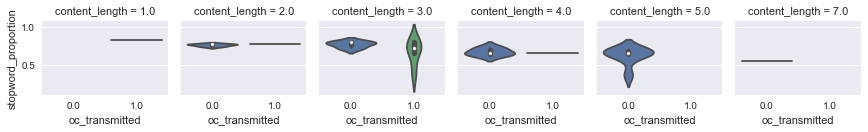

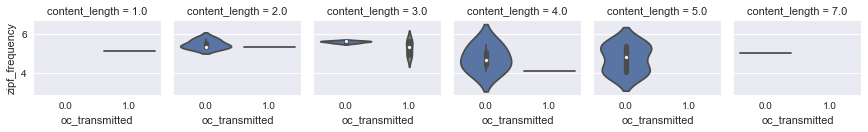

In [22]:
data_transmitted_lengths, features_transmitted_lengths = \
    extract_features(data, index, ['oc_rate', 'oc_transmitted', 'token_length', 'content_length'])
for feature in features_transmitted_lengths:
    g = sb.factorplot(y='value', x='oc_transmitted',
                      data=data_transmitted_lengths[data_transmitted_lengths.feature == feature],
                      col='content_length', col_wrap=10,
                      kind='violin', size=2)
    g.set_ylabels(feature)

### 2.4 Transformation rate ~ feature

#### 2.4.1 Content words transformation rate ~ feature

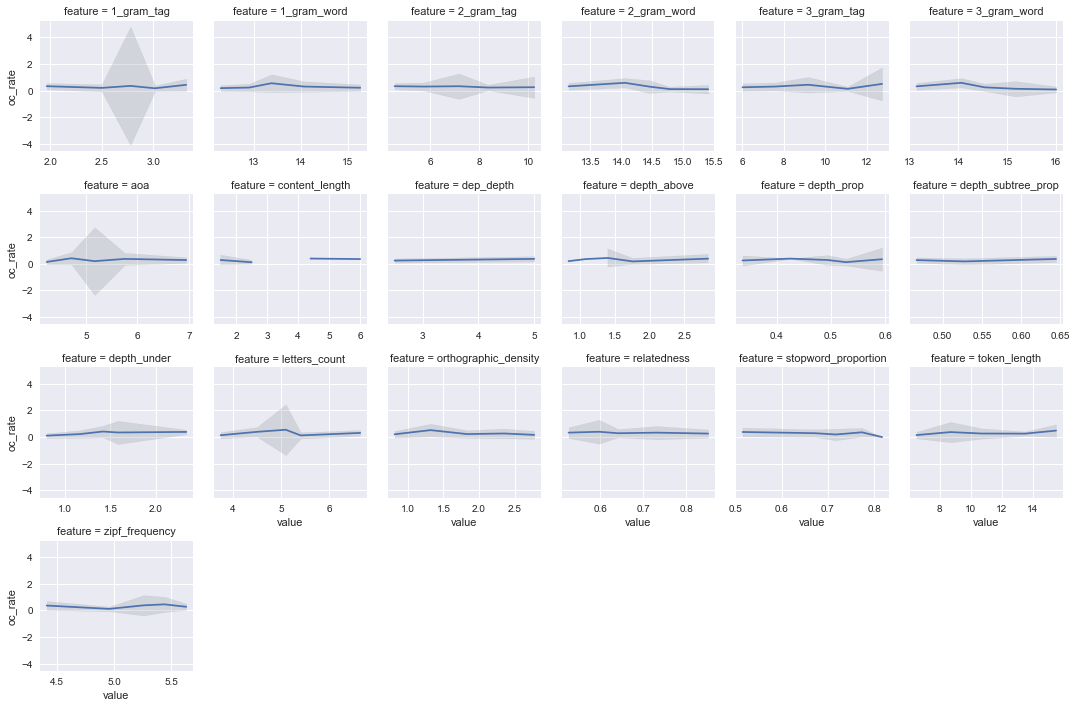

In [23]:
g = sb.FacetGrid(data=data_transmitted,
                 dropna=False, col='feature', col_order=features_transmitted,
                 col_wrap=6, size=2.5, sharex=False)
g.map_dataframe(plot_relation, 'value', 'oc_rate', binning=5, quantiles=True).add_legend()
#g.set(ylim=(0, .09))

#### 2.4.2 Content words transformation rate ~ feature / number of content words

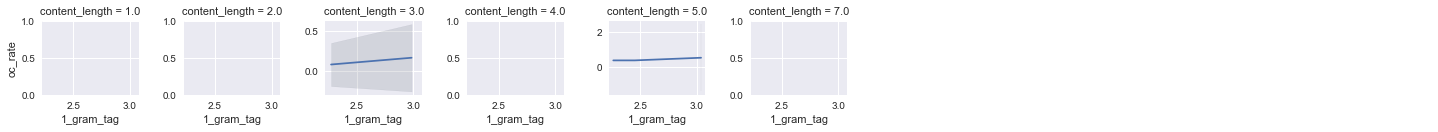

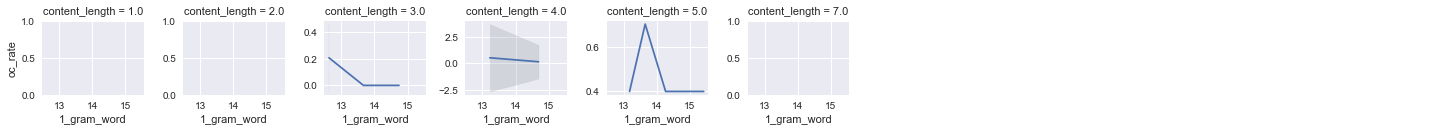

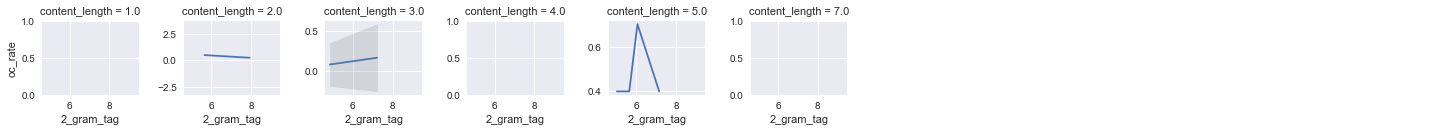

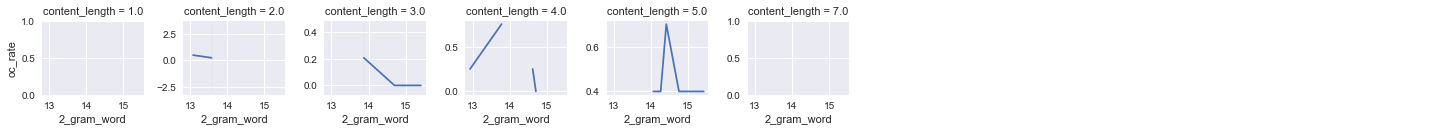

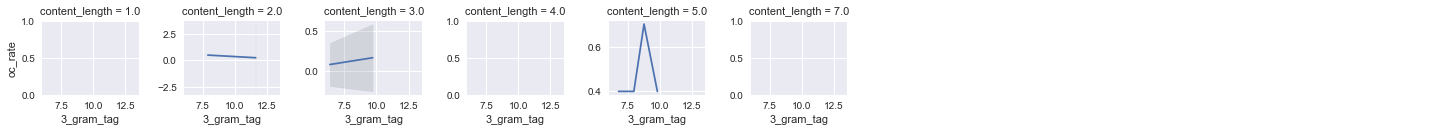

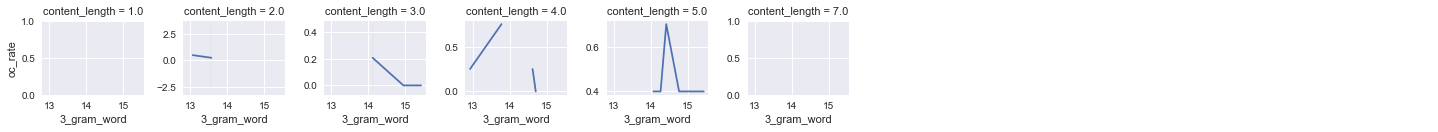

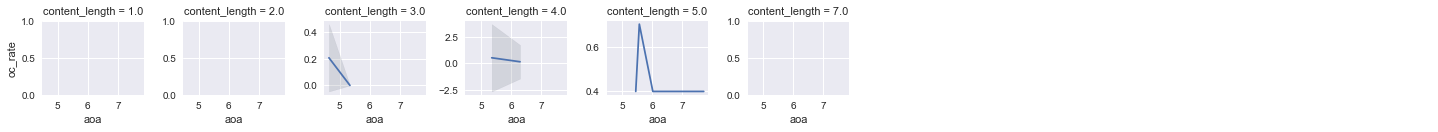

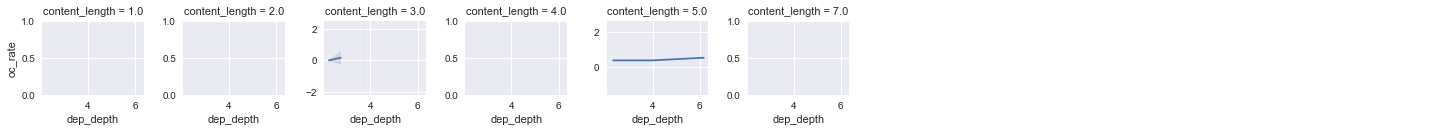

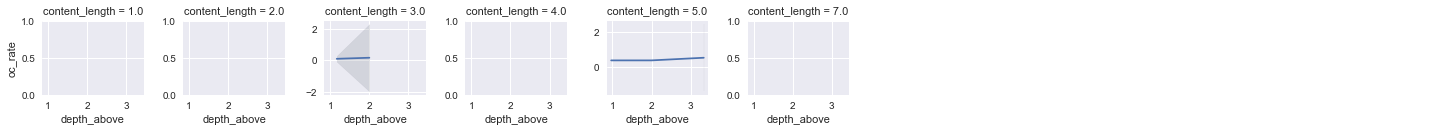

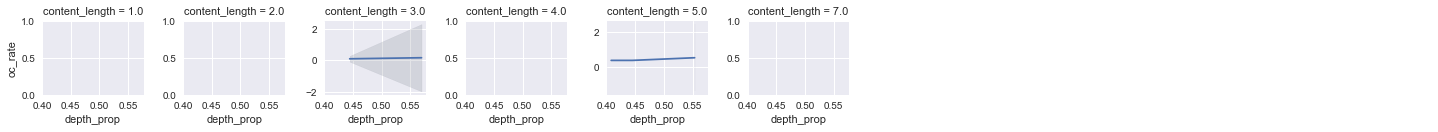

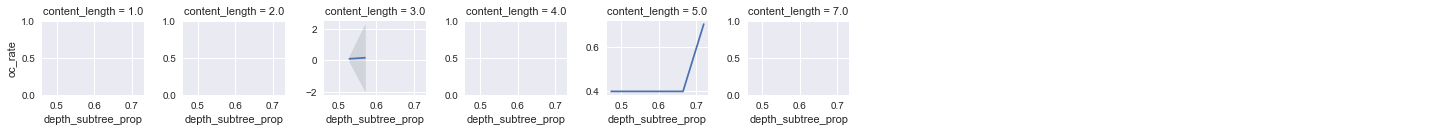

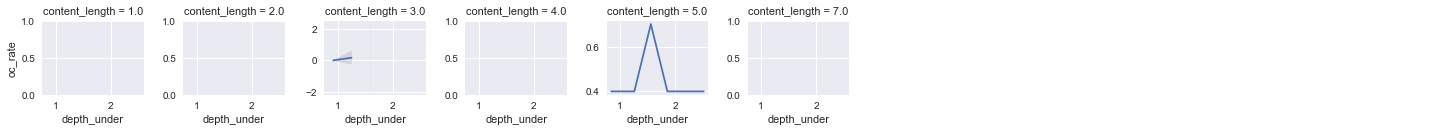

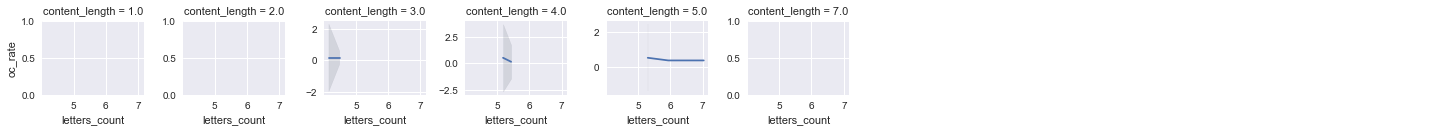

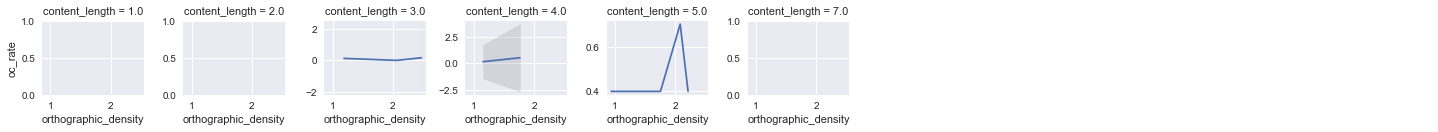

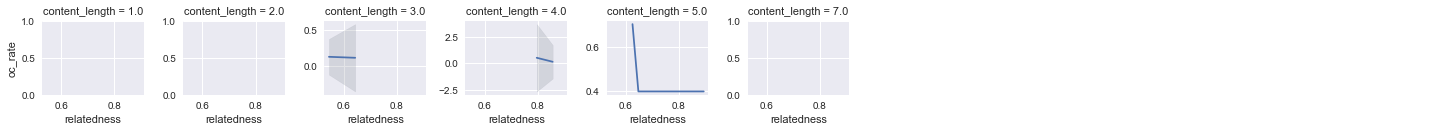

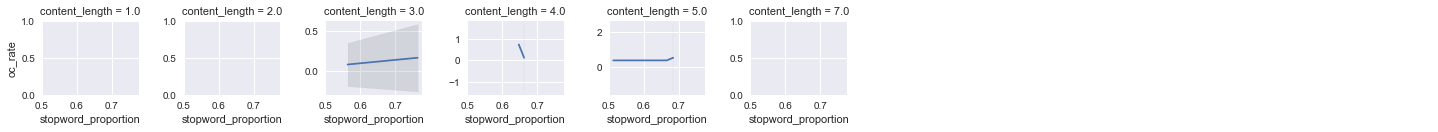

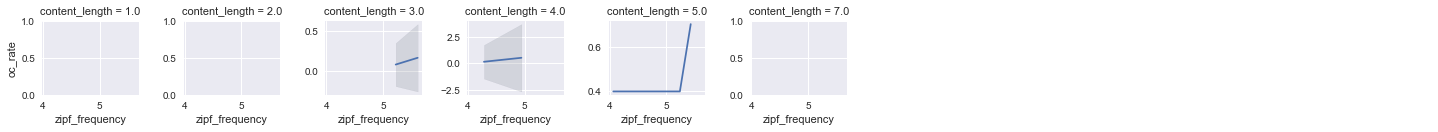

In [24]:
for feature in features_transmitted_lengths:
    g = sb.FacetGrid(data=data_transmitted_lengths[data_transmitted_lengths.feature == feature],
                     dropna=False, col='content_length',
                     sharey=False,
                     col_wrap=10, size=2)
    g.map_dataframe(plot_relation, 'value', 'oc_rate',
                    binning=5, quantiles=True).add_legend()
    g.set_xlabels(feature)

Note: to implement variability graphs (i.e. plotting std of a value across branches, at a given depth, to quantify the average distance between branches), we need CIs on the standard deviation, to be implemented following [Bonnet (2006)](https://pdfs.semanticscholar.org/2488/129d6d00cd42361cf30f03e1abae3ac717de.pdf) ([Cho, Cho, & Eltinge (2005)](http://www.ijpam.eu/contents/2005-21-3/10/10.pdf) might also be useful). It's not trivial, so I won't be doing it soon.

## 3 Sentence feature step-change

### 3.0 Setup

Build the DataFrame that we'll plot below

In [25]:
sentence_indexed = data.set_index(['sentence_id', 'branch_id', 'feature'], verify_integrity=True)
child_indexed = data.set_index(['child_id', 'branch_id', 'feature'], verify_integrity=True)
child_indexed['child_value'] = sentence_indexed.value
transition_data = child_indexed.reset_index()

And add a variation-plotting function used below

In [26]:
def plot_variation(x, y, **kwargs):
    data = kwargs.pop('data')
    ax = kwargs.get('ax', plt.gca())
    color = kwargs.get('color', sb.color_palette()[0])
    binning = kwargs.get('binning')
    if isinstance(x, str):
        x_name = x
        x = data[x]
    if isinstance(y, str):
        y_name = y
        y = data[y]
    
    # Compute binning.
    if (x.values.astype(int) == x).all():
        binning = None
    if binning is not None:
        for bin_count in range(binning, 0, -1):
            try:
                x_bins, bins = pd.cut(x, bin_count, labels=False,
                                      retbins=True, right=False)
                break
            except ValueError:
                pass
        if bin_count <= 1:
            return
        middles = (bins[:-1] + bins[1:]) / 2
    else:
        middles = np.arange(x.values.min(), x.values.max() + 1)
        x_bins = x.values - x.values.min()
        bin_count = len(middles)
    
    # Compute bin values.
    values = np.zeros(bin_count)
    cis = np.zeros(bin_count)
    for i in range(bin_count):
        indices = x_bins == i
        n = indices.sum()
        values[i] = y[indices].mean()
        cis[i] = (stats.t.ppf(1 - 0.5/2, n - 1) * y[indices].std(ddof=1)
                  / np.sqrt(n))
    
    # Plot.
    ax.plot(middles, values, '-', lw=2, color=color)
    ax.fill_between(middles, values - cis, values + cis,
                    color=sb.desaturate(color, 0.2), alpha=0.2)
    ax.plot(middles, middles, linestyle='dotted',
            color=sb.desaturate(color, 0.2))

### 3.1 Parent feature ~ child feature

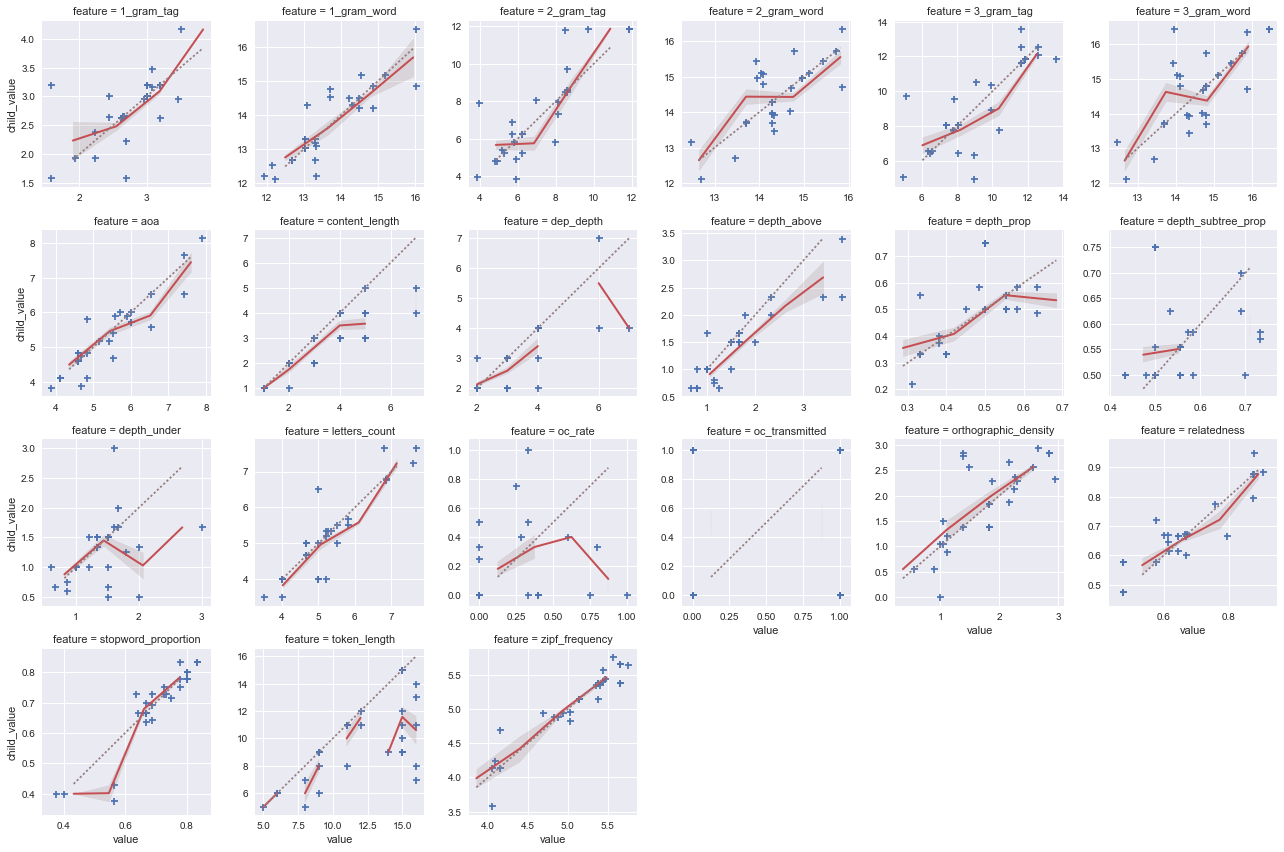

In [27]:
g = sb.FacetGrid(data=transition_data,
                 dropna=False, col='feature', col_order=features,
                 col_wrap=6, size=3, sharex=False, sharey=False)
g.map_dataframe(plt.scatter, 'value', 'child_value', marker='+')
g.map_dataframe(plot_variation, 'value', 'child_value',
                binning=4, color=sb.color_palette()[2])